# Moyenne multi-modèle - Cartes saisonnière (référence 1850-1900)

In [1]:
from watermark import watermark
%load_ext watermark
print(watermark())

Last updated: 2025-06-10T07:40:26.604032+00:00

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.17.2

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 6.8.0-58-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D
from skimage.measure import find_contours
import os
import calendar
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

In [3]:
%watermark --iversions

numpy     : 2.0.2
skimage   : 0.25.0
watermark : 2.5.0
cartopy   : 0.24.0
pandas    : 2.2.3
xarray    : 2025.1.1
matplotlib: 3.10.0



## Définition des fonctions

In [4]:
# je définis mes données
def get_data(path_snc, path_areacella, path_sftlf):
    ds_snc = xr.open_dataset(path_snc)
    ds_area = xr.open_dataset(path_areacella)
    ds_sftlf = xr.open_dataset(path_sftlf)
    return ds_snc, ds_area, ds_sftlf

def extraction_variable(ds_snc, variable="sncbin", lat_min=20):
    snc = ds_snc[variable]

    if lat_min is not None:
        snc = snc.sel(lat=snc.lat>=lat_min)

    snc = snc.where(snc< 1e19, float("nan"))

    max_val = snc.max().item()
    if max_val > 1.5:
        print(f"La variable '{variable}' est en %. Conversion en fraction.")
        snc = snc/100

    if sftlf is not None:
        snc = snc.where(sftlf>50)

    snc = snc.clip(0, 1)

    return snc

In [5]:
files = os.listdir("/home/jovyan/private-storage/interp_models_SW/")

nc_files = [filename for filename in files if filename.endswith(".nc")]
nc_files

['BCC-CSM2-MR_SW_reprojete.nc',
 'CanESM5_SW_reprojete.nc',
 'CanESM5-CanOE_SW_reprojete.nc',
 'CESM2_SW_reprojete.nc',
 'CESM2-WACCM_SW_reprojete.nc',
 'CIESM_SW_reprojete.nc',
 'CNRM-CM6-1_SW_reprojete.nc',
 'CNRM-CM6-1-HR_SW_reprojete.nc',
 'CNRM-ESM2-1_SW_reprojete.nc',
 'EC-Earth3_SW_reprojete.nc',
 'EC-Earth3-Veg_SW_reprojete.nc',
 'FGOALS-f3-L_SW_reprojete.nc',
 'FGOALS-g3_SW_reprojete.nc',
 'GFDL-CM4_SW_reprojete.nc',
 'GISS-E2-1-G_SW_reprojete.nc',
 'HadGEM3-GC31-LL_SW_reprojete.nc',
 'IPSL-CM6A-LR_SW_reprojete.nc',
 'MIROC-ES2L_SW_reprojete.nc',
 'MIROC6_SW_reprojete.nc',
 'MPI-ESM1-2-HR_SW_reprojete.nc',
 'MPI-ESM1-2-LR_SW_reprojete.nc',
 'MRI-ESM2-0_SW_reprojete.nc',
 'NorESM2-LM_SW_reprojete.nc',
 'NorESM2-MM_SW_reprojete.nc',
 'UKESM1-0-LL_SW_reprojete.nc']

## Snow Reference

In [6]:
path_snow_ref = os.path.join("~/private-storage/output_data/", "snow_reference.nc")
snow_ref = xr.open_dataset(path_snow_ref)
snow_ref = snow_ref["snow_cover_extent"]
snow_ref

<xarray.DataArray 'snow_cover_extent' (month: 12, lat: 180, lon: 360)> Size: 3MB
[777600 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    standard_name:  surface_snow_binary_mask
    long_name:      NOAA/NCEI Climate Data Record of snow cover extent
    cell_methods:   time: mean
    flag_values:    [0 1]
    flag_meanings:  no_snow snow_covered

In [7]:
path = "/home/jovyan/private-storage/grid/"
file = "area.nc"
area = xr.open_dataset(os.path.join(path, file))

In [8]:
season_months = {
    "DJF": [12, 1, 2],
    "MAM": [3, 4, 5],
    "JJA": [6, 7, 8],
    "SON": [9, 10, 11]
}

In [9]:
seasonal_snow_reference = {}

for season, months in season_months.items():
    months_float = [float(m) for m in months]
    da_sel = snow_ref.sel(month=months_float)
    seasonal_snow_reference[season] = da_sel.mean(dim="month", skipna=True)

In [10]:
djf_snow_reference = seasonal_snow_reference['DJF']
mam_snow_reference = seasonal_snow_reference['MAM']
jja_snow_reference = seasonal_snow_reference['JJA']
son_snow_reference = seasonal_snow_reference['SON']

## Moyenne multi-modèles avec application des scores fonction gaussienne

In [11]:
scores_modeles = pd.read_csv("~/private-storage/fichiers_csv/scores_modeles.csv", index_col=0)
scores_modeles

,Erreur_moyenne,Scores_exp,Scores_gauss
MRI_ESM2_0,1.266978e+06,1.000000,1.000000
FGOALS_f3_L,1.609116e+06,0.968784,0.991986
NorESM2_LM,1.851120e+06,0.947293,0.976818
NorESM2_MM,1.869009e+06,0.945724,0.975395
IPSL_CM6A_LR,1.927405e+06,0.940619,0.970464
CIESM,1.962490e+06,0.937564,0.967296
CanESM5,2.056824e+06,0.929402,0.958024
CanESM5_CanOE,2.183057e+06,0.918590,0.943948
CESM2_WACCM,2.201268e+06,0.917041,0.941764
BCC_CSM2_MR,2.286914e+06,0.909790,0.930991


In [12]:
snow_cover_dict = {}

for i, files in enumerate(nc_files):
    model_name = files.split("_")[0]
    
    path_snc = os.path.join("/home/jovyan/private-storage/interp_models_SW/", files)
    path_areacella = os.path.join("/home/jovyan/private-storage/areacella_recalcule_cdo_bis/", files.replace("SW_reprojete", "gridarea_hist_recalcule"))
    path_sftlf = os.path.join("/home/jovyan/private-storage/interp_sftlf_bis/", files.replace("SW", "sftlf"))
                                 
    ds_snc, ds_area, ds_sftlf = get_data(path_snc, path_areacella, path_sftlf)
    sftlf = ds_sftlf["sftlf"]
    snc = extraction_variable(ds_snc)

    snow_cover_dict[model_name] = snc

La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variable 'sncbin' est en %. Conversion en fraction.
La variabl

In [13]:
for model, da in snow_cover_dict.items():
    if 'type' in da.coords:
        print(f"{model}: {da['type'].values}")

CanESM5: b'land'
CNRM-CM6-1: b'typeland'
CNRM-CM6-1-HR: b'typeland'
CNRM-ESM2-1: b'typeland'
GISS-E2-1-G: b'land'
HadGEM3-GC31-LL: b'land'
IPSL-CM6A-LR: b'typeland'
MIROC-ES2L: b'land'
MIROC6: b'land'
MRI-ESM2-0: b'land'
UKESM1-0-LL: b'land'


In [14]:
cleaned_snc = []
model_names = []

for model, da in snow_cover_dict.items():
    if 'type' in da.coords:
        da = da.drop_vars('type')

    cleaned_snc.append(da)
    model_names.append(model)

In [15]:
all_snc = xr.concat(cleaned_snc, dim=xr.DataArray(model_names, dims="model"))

In [16]:
# création du vecteur de poids de chaque modèle suivant score obtenu
weights = xr.DataArray(
    scores_modeles["Scores_gauss"],
    coords = {"modele_x": scores_modeles.index},
    dims="modele_x"
)

In [17]:
weights = weights.rename({"modele_x": "model"})
weights = weights.assign_coords(
    model=[m.replace("_", "-") for m in weights.model.values]
)

In [18]:
weighted = all_snc * weights
weighted

<xarray.DataArray (model: 25, GSAT: 23, month: 12, lat: 70, lon: 360)> Size: 1GB
array([[[[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
...
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]]]])
Coordinates:
  * month    (month) float32 48B 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0
  * GSAT     (GSAT) float32 92B -0.5 -0.25 0.0 0.25 0.5 ... 4.25 4.5 4.75 5.0
  * lat      (lat) float64 560B 20.5 21.5 22.5 23.5 24.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * model    (model) <U15 2kB 'BCC-CSM2-MR' 'CanESM5' ... 'UKESM1-0-LL'

In [19]:
all_snc, weights = xr.align(all_snc, weights, join="inner")

In [20]:
mean_snc_pondere = (all_snc * weights).sum(dim="model") / weights.sum(dim="model")

In [21]:
snc_gsat_05_pondere = mean_snc_pondere.sel(GSAT=-0.5)
snc_gsat0_pondere = mean_snc_pondere.sel(GSAT=0.0)
snc_gsat1_pondere = mean_snc_pondere.sel(GSAT=1.0)
snc_gsat2_pondere = mean_snc_pondere.sel(GSAT=2.0)
snc_gsat3_pondere = mean_snc_pondere.sel(GSAT=3.0)
snc_gsat4_pondere = mean_snc_pondere.sel(GSAT=4.0)
snc_gsat5_pondere = mean_snc_pondere.sel(GSAT=5.0)

## Définition des saisons

In [22]:
# définition des saisons
season_months = {
    "DJF": [12, 1, 2],
    "MAM": [3, 4, 5],
    "JJA": [6, 7, 8],
    "SON": [9, 10, 11]
}

In [23]:
seasonal_mean_snc_pondere = {}

for season, months in season_months.items():
    months_float = [float(m) for m in months]
    da_sel = mean_snc_pondere.sel(month=months_float)
    seasonal_mean_snc_pondere[season] = da_sel.mean(dim="month", skipna=True)

In [24]:
seasonal_snc_binary_50_pondere = {
    season: xr.where(da >= 0.15, 1, 0).where(~da.isnull())
    for season, da in seasonal_mean_snc_pondere.items()
}

In [25]:
djf_snc_gsat05 = seasonal_snc_binary_50_pondere['DJF'].sel(GSAT=-0.5)
djf_snc_gsat0 = seasonal_snc_binary_50_pondere['DJF'].sel(GSAT=0)
djf_snc_gsat1 = seasonal_snc_binary_50_pondere['DJF'].sel(GSAT=1)
djf_snc_gsat2 = seasonal_snc_binary_50_pondere['DJF'].sel(GSAT=2)
djf_snc_gsat3 = seasonal_snc_binary_50_pondere['DJF'].sel(GSAT=3)
djf_snc_gsat4 = seasonal_snc_binary_50_pondere['DJF'].sel(GSAT=4)
djf_snc_gsat5 = seasonal_snc_binary_50_pondere['DJF'].sel(GSAT=5)

In [26]:
mam_snc_gsat05 = seasonal_snc_binary_50_pondere['MAM'].sel(GSAT=-0.5)
mam_snc_gsat0 = seasonal_snc_binary_50_pondere['MAM'].sel(GSAT=0)
mam_snc_gsat1 = seasonal_snc_binary_50_pondere['MAM'].sel(GSAT=1)
mam_snc_gsat2 = seasonal_snc_binary_50_pondere['MAM'].sel(GSAT=2)
mam_snc_gsat3 = seasonal_snc_binary_50_pondere['MAM'].sel(GSAT=3)
mam_snc_gsat4 = seasonal_snc_binary_50_pondere['MAM'].sel(GSAT=4)
mam_snc_gsat5 = seasonal_snc_binary_50_pondere['MAM'].sel(GSAT=5)

In [27]:
jja_snc_gsat05 = seasonal_snc_binary_50_pondere['JJA'].sel(GSAT=-0.5)
jja_snc_gsat0 = seasonal_snc_binary_50_pondere['JJA'].sel(GSAT=0)
jja_snc_gsat1 = seasonal_snc_binary_50_pondere['JJA'].sel(GSAT=1)
jja_snc_gsat2 = seasonal_snc_binary_50_pondere['JJA'].sel(GSAT=2)
jja_snc_gsat3 = seasonal_snc_binary_50_pondere['JJA'].sel(GSAT=3)
jja_snc_gsat4 = seasonal_snc_binary_50_pondere['JJA'].sel(GSAT=4)
jja_snc_gsat5 = seasonal_snc_binary_50_pondere['JJA'].sel(GSAT=5)

In [28]:
son_snc_gsat05 = seasonal_snc_binary_50_pondere['SON'].sel(GSAT=-0.5)
son_snc_gsat0 = seasonal_snc_binary_50_pondere['SON'].sel(GSAT=0)
son_snc_gsat1 = seasonal_snc_binary_50_pondere['SON'].sel(GSAT=1)
son_snc_gsat2 = seasonal_snc_binary_50_pondere['SON'].sel(GSAT=2)
son_snc_gsat3 = seasonal_snc_binary_50_pondere['SON'].sel(GSAT=3)
son_snc_gsat4 = seasonal_snc_binary_50_pondere['SON'].sel(GSAT=4)
son_snc_gsat5 = seasonal_snc_binary_50_pondere['SON'].sel(GSAT=5)

In [29]:
def plot_snow_on_ax(ax, datas, snow_ref, season_label, sftlf, colors):
    data_crs = ccrs.PlateCarree()
    land_mask = sftlf > 50

    for label, da in datas.items():
        mask = (da == 1) & land_mask
        lon2d, lat2d = np.meshgrid(da.lon, da.lat)
        gsat_label = label.split("_")[1] if "reference" not in label else "0°C-ref"

        ax.contourf(
            lon2d, lat2d, mask,
            levels=[0.15, 1],
            colors=[colors[gsat_label]],
            transform=data_crs,
            alpha=0.6
        )

    if snow_ref is not None:
        snow_mask = (snow_ref > 0.15)
        lon2d, lat2d = np.meshgrid(snow_ref.lon, snow_ref.lat)
        ax.contour(
            lon2d, lat2d, snow_mask,
            levels=[0.15],
            colors='red',
            linewidths=1.3,
            transform=data_crs
        )

    ax.coastlines()
    ax.set_extent([-180, 180, 25, 90], crs=data_crs)
    ax.set_title(f'{season_label}', fontsize=22)
    gl = ax.gridlines(draw_labels=True, color='gray', linewidth=0.5, linestyle='-')
    gl.xlabel_style={'size':16}
    gl.ylabel_style={'size':16}

def adjust_label(label):
    if label == "0°C-ref":
        return "Observations"
    try:
        temp_val = float(label.replace("°C", ""))
        return f"+{temp_val + 0}°C"
    except ValueError:
        return label

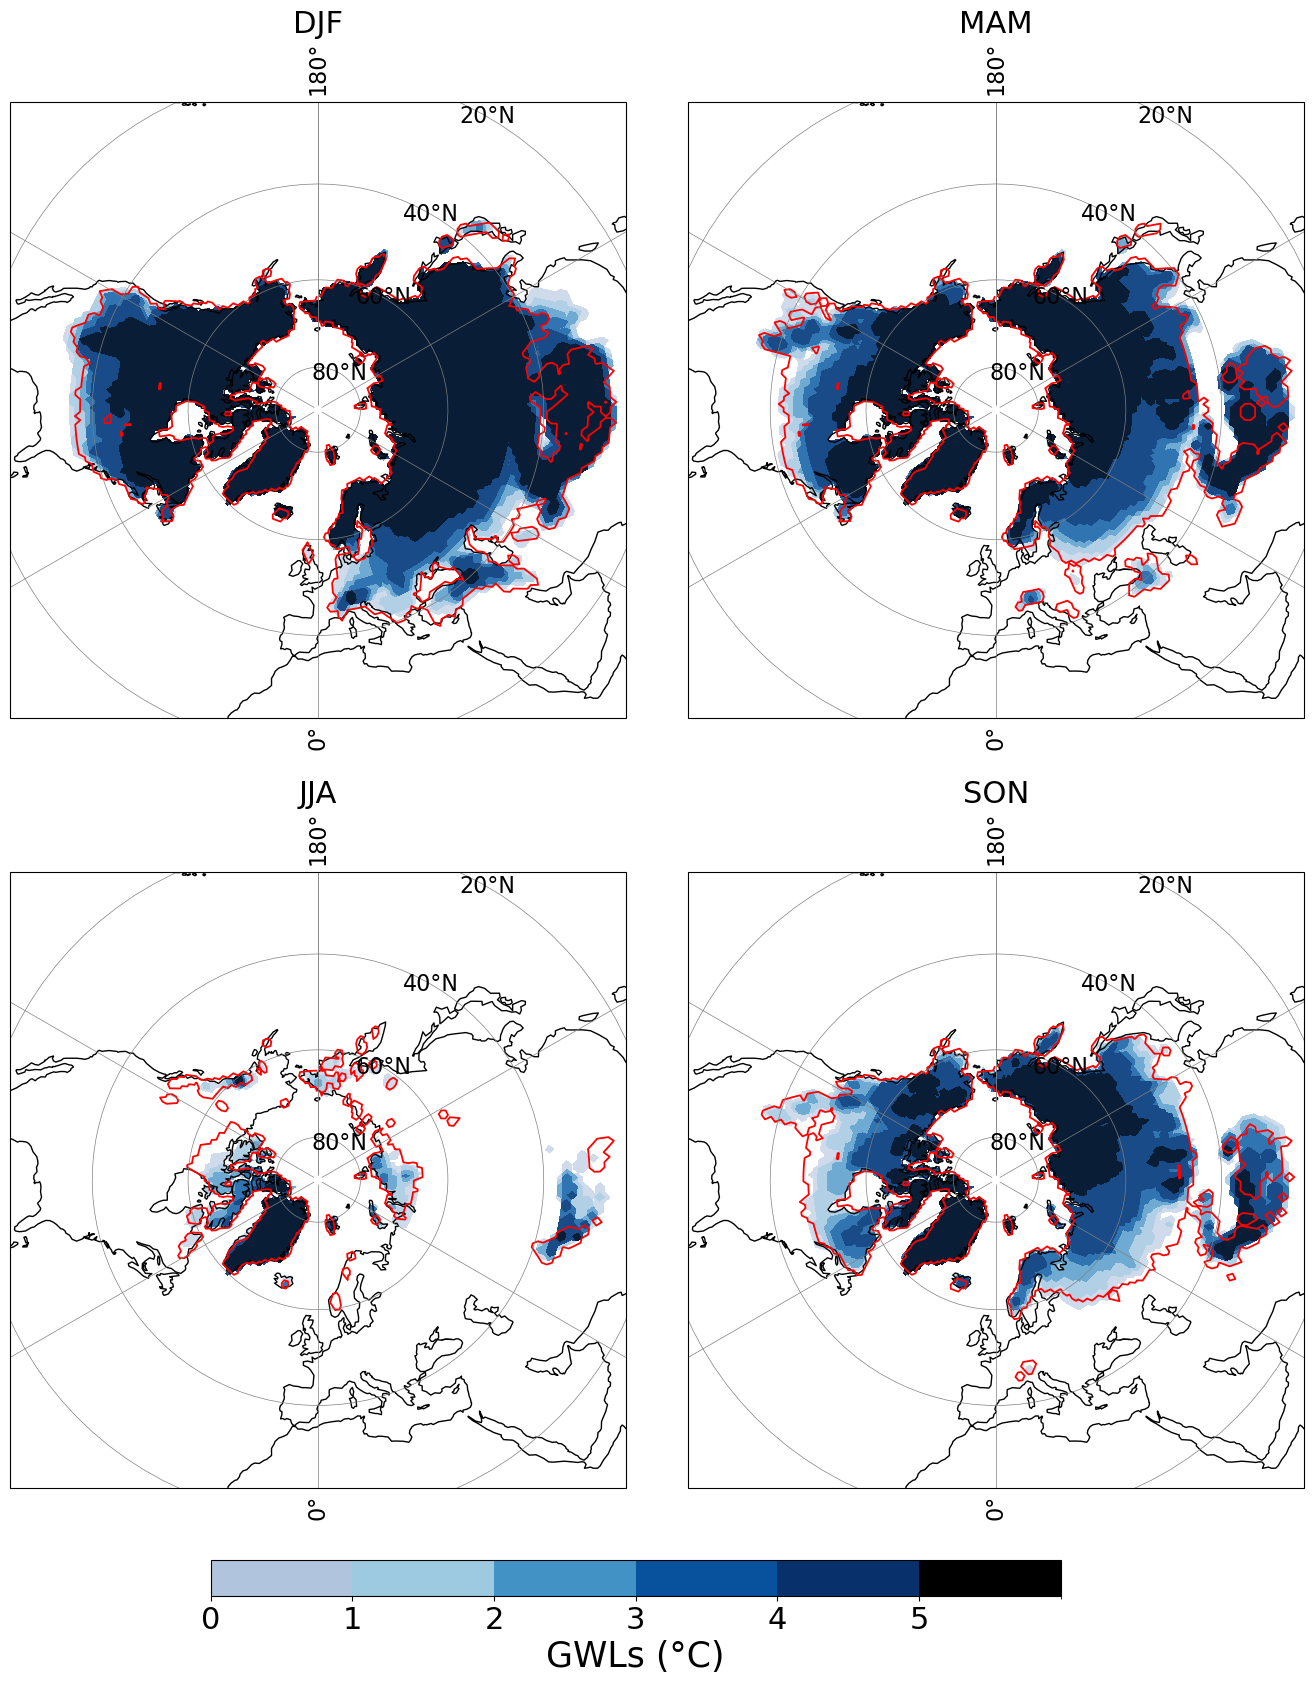

In [30]:
# Couleurs
colors = {
    "0°C-ref": "red",
    "-0.5°C": "paleturquoise",
    "0°C": "lightsteelblue",
    "1°C": "#9ECAE1",
    "2°C": "#4292C6",
    "3°C": "#08519C",
    "4°C": "#08306B",
    "5°C": "black"
}

# Dictionnaire données par saison
season_data = {
    "DJF": {
        "datas": {
            "snow_-0.5°C": djf_snc_gsat05,
            "snow_0°C": djf_snc_gsat0,
            "snow_1°C": djf_snc_gsat1,
            "snow_2°C": djf_snc_gsat2,
            "snow_3°C": djf_snc_gsat3,
            "snow_4°C": djf_snc_gsat4,
            "snow_5°C": djf_snc_gsat5,
        },
        "ref": djf_snow_reference
    },
    "MAM": {
        "datas": {
            "snow_-0.5°C": mam_snc_gsat05,
            "snow_0°C": mam_snc_gsat0,
            "snow_1°C": mam_snc_gsat1,
            "snow_2°C": mam_snc_gsat2,
            "snow_3°C": mam_snc_gsat3,
            "snow_4°C": mam_snc_gsat4,
            "snow_5°C": mam_snc_gsat5,
        },
        "ref": mam_snow_reference
    },
    "JJA": {
        "datas": {
            "snow_-0.5°C": jja_snc_gsat05,
            "snow_0°C": jja_snc_gsat0,
            "snow_1°C": jja_snc_gsat1,
            "snow_2°C": jja_snc_gsat2,
            "snow_3°C": jja_snc_gsat3,
            "snow_4°C": jja_snc_gsat4,
            "snow_5°C": jja_snc_gsat5,
        },
        "ref": jja_snow_reference
    },
    "SON": {
        "datas": {
            "snow_-0.5°C": son_snc_gsat05,
            "snow_0°C": son_snc_gsat0,
            "snow_1°C": son_snc_gsat1,
            "snow_2°C": son_snc_gsat2,
            "snow_3°C": son_snc_gsat3,
            "snow_4°C": son_snc_gsat4,
            "snow_5°C": son_snc_gsat5,
        },
        "ref": son_snow_reference
    }
}

# Création de la figure
fig, axes = plt.subplots(2, 2, figsize=(17, 18), subplot_kw={'projection': ccrs.NorthPolarStereo()})
axes = axes.flatten()

# Tracé pour chaque saison
for ax, (season, content) in zip(axes, season_data.items()):
    plot_snow_on_ax(ax, content["datas"], content["ref"], season, sftlf, colors)

# Vraie échelle de couleurs
temps = [0, +1, +2, +3, +4, +5]
color_list = [
    "lightsteelblue",
    "#9ECAE1",
    "#4292C6",
    "#08519C",
    "#08306B",
    "black"
]

# Création de la colormap
cmap = mcolors.ListedColormap(color_list)
norm = mcolors.BoundaryNorm(boundaries=temps + [5.5], ncolors=len(color_list))  # +4.5 to extend upper limit

# Création de la colorbar
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap),
                    cax=cbar_ax,
                    orientation='horizontal',
                    ticks=temps)
cbar.set_label("GWLs (°C)", fontsize=25)
cbar.ax.tick_params(labelsize=22)

# Titre
plt.subplots_adjust(wspace=0.06, hspace=0.25)

plt.savefig("figures/seasonal_snow_extension_1850_1900_15%.png")
plt.show()

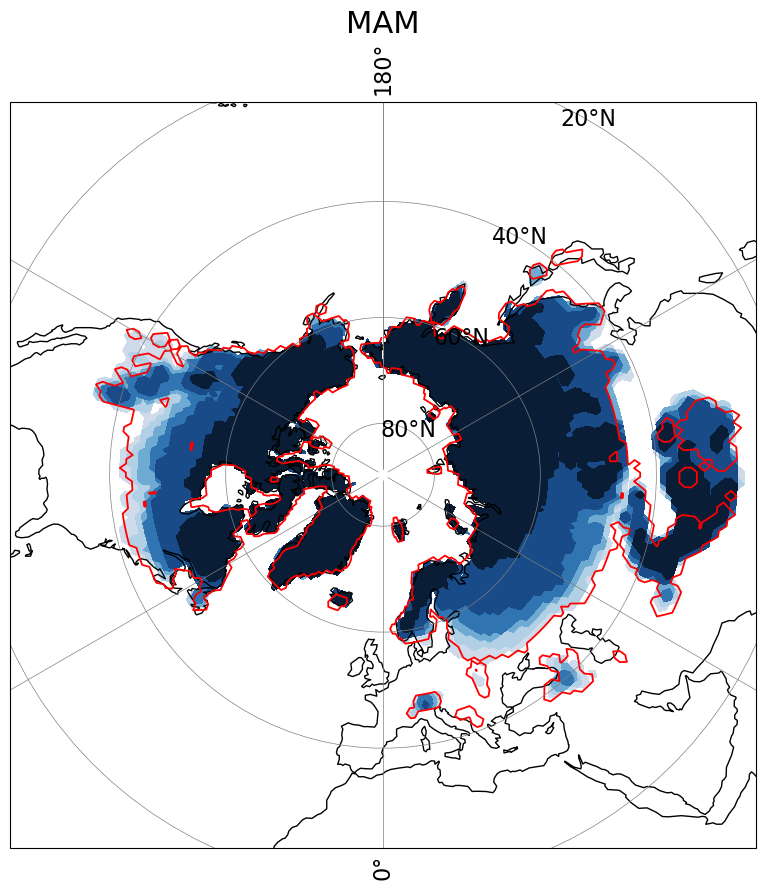

In [47]:
# Couleurs
colors = {
    "0°C-ref": "red",
    "-0.5°C": "paleturquoise",
    "0°C": "lightsteelblue",
    "1°C": "#9ECAE1",
    "2°C": "#4292C6",
    "3°C": "#08519C",
    "4°C": "#08306B",
    "5°C": "black"
}

# Données du printemps uniquement
mam_data = {
    "snow_-0.5°C": mam_snc_gsat05,
    "snow_0°C": mam_snc_gsat0,
    "snow_1°C": mam_snc_gsat1,
    "snow_2°C": mam_snc_gsat2,
    "snow_3°C": mam_snc_gsat3,
    "snow_4°C": mam_snc_gsat4,
    "snow_5°C": mam_snc_gsat5,
}
mam_ref = mam_snow_reference

# Création de la figure pour MAM
fig, ax = plt.subplots(1, 1, figsize=(9, 9), subplot_kw={'projection': ccrs.NorthPolarStereo()})

# Tracé
plot_snow_on_ax(ax, mam_data, mam_ref, "MAM", sftlf, colors)

# Échelle de couleurs
#temps = [0, +1, +2, +3, +4, +5]
#color_list = [
#    "lightsteelblue",
#    "#9ECAE1",
#    "#4292C6",
#    "#08519C",
#    "#08306B",
#    "black"
#]

# Création de la colormap
#cmap = mcolors.ListedColormap(color_list)
#norm = mcolors.BoundaryNorm(boundaries=temps + [5.5], ncolors=len(color_list))

# Colorbar
#cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.02])
#cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap),
                    #cax=cbar_ax,
                    #orientation='horizontal',
                    #ticks=temps)
#cbar.set_label("GWLs (°C)", fontsize=20)
#cbar.ax.tick_params(labelsize=18)

plt.tight_layout()
plt.savefig("figures/spring_snow_extension_1850_1900_15%.png")
plt.show()
